# Natural Language Understanding (NLU) system to classify intents from text inputs


### Features of the system
- Classify intents based on given texts.
- Give confidence scores based on the output results.
- Give fallback response if predicted intent does not meet the predefined threshold.

## Data Gathering & Understanding

In [16]:
!pip install autocorrect
from autocorrect import Speller

In [17]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [18]:
import pandas as pd

# Read the data from the text file
with open('data.txt', 'r') as file:
    data = file.readlines()

# Initialize lists to store intents and examples
intents = []
examples = []

# Initialize counter for intent numbering
intent_counter = 0

# Iterate through the lines and extract intents and examples
current_intent = None
for line in data:
    if line.strip().startswith(str(intent_counter + 1) + '. **'):
        current_intent = line.split('**')[1]
        intent_counter += 1
    elif line.strip().startswith('-'):
        example = line.split('-')[1].strip()
        intents.append(current_intent)
        examples.append(example)

# Create a DataFrame
df = pd.DataFrame({'intent': intents, 'example': examples})

# Save the DataFrame to an Excel file
df.to_excel('intents_examples.xlsx', index=False)


In [19]:
df.head(10)

,intent,example
0,Greetings:,Hello there!
1,Greetings:,Good morning!
2,Greetings:,"Hi, how are you?"
3,Greetings:,"Hey, what's up?"
4,Greetings:,"Hi, nice to meet you!"
5,Greetings:,Good afternoon!
6,Greetings:,"Hi there, how's your day?"
7,Greetings:,"Hello, how can I help you?"
8,Greetings:,"Hey, long time no see!"
9,Greetings:,"Hi, how have you been?"


In [20]:
df.shape

(240, 2)

In [21]:
# Assuming df is your DataFrame
unique_categories = df['intent'].unique()
print(unique_categories)


['Greetings:' 'Farewells:' 'Inquiry:' 'Expressing Gratitude:' 'Apologies:'
 'Expressing Emotions:' 'Making Suggestions:' 'Making Excuse'
 'Expressing Preferences:' 'Expressing Congratulations:']


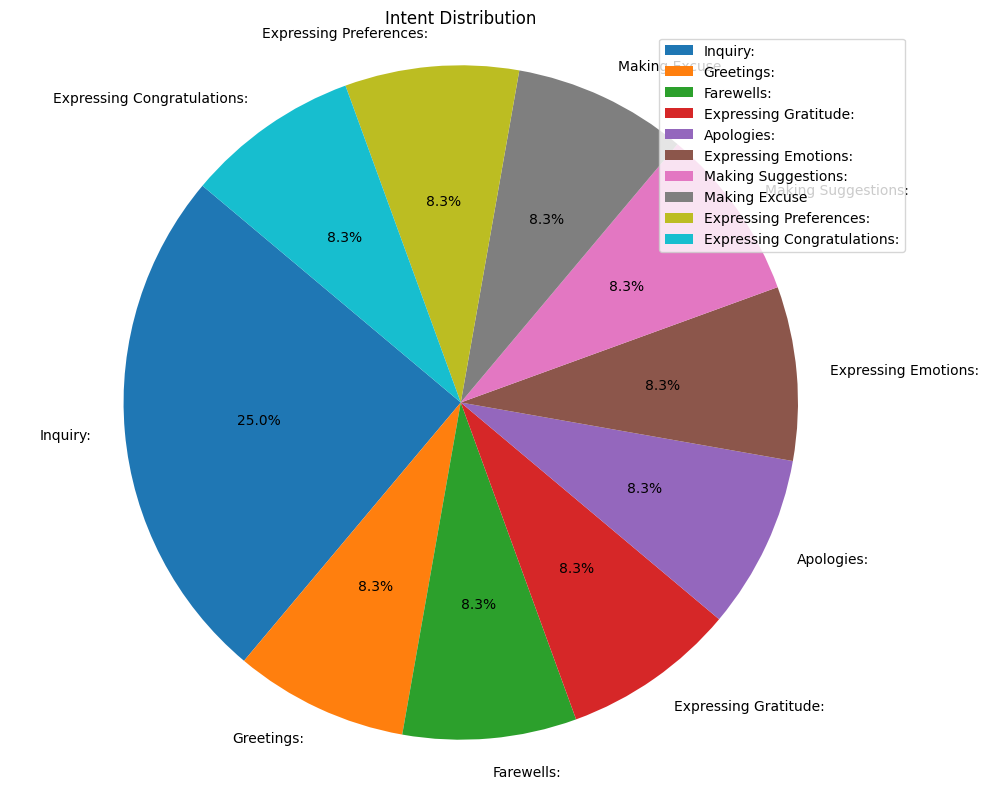

In [22]:
# Plot intent distribution as a pie chart
plt.figure(figsize=(10, 8))
intent_counts = df['intent'].value_counts()
intent_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Intent Distribution')
plt.ylabel('')  # Remove y-label
plt.legend(labels=intent_counts.index, loc='upper right')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

## Data Pre-Processing

In [23]:
from autocorrect import Speller

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize spelling checker
spell = Speller(lang='en')


# Function for spelling correction
def correct_spelling(text):
    corrected_text = []
    for word in text.split():
        corrected_text.append(spell(word))
    return ' '.join(corrected_text)

# Function to perform preprocessing
def preprocess_text(text):
    # Lowercasing
    text = text.lower()


    # Removing punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Join tokens back to text
    cleaned_text = ' '.join(lemmatized_tokens)

    return cleaned_text

# Apply preprocessing to 'examples' column and create a new 'cleaned' column
df['cleaned'] = df['example'].apply(preprocess_text)

df.head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,intent,example,cleaned
0,Greetings:,Hello there!,hello
1,Greetings:,Good morning!,good morning
2,Greetings:,"Hi, how are you?",hi
3,Greetings:,"Hey, what's up?",hey whats
4,Greetings:,"Hi, nice to meet you!",hi nice meet


## Data Visualizng

In [24]:
from wordcloud import WordCloud

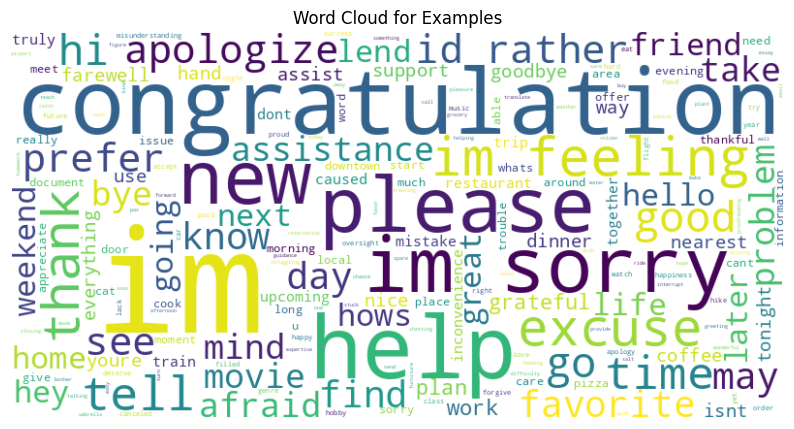

In [25]:
# Generate word cloud from the 'cleaned' column
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned']))

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Examples')
plt.axis('off')  # Hide axes
plt.show()


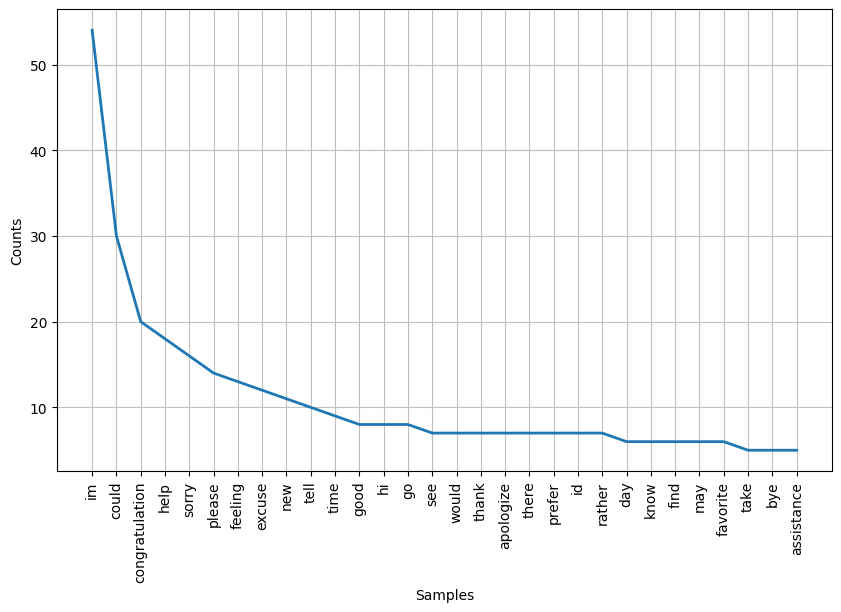

<Axes: xlabel='Samples', ylabel='Counts'>

In [26]:
from nltk.probability import FreqDist


# Tokenize the cleaned text and calculate word frequencies
all_words = nltk.tokenize.word_tokenize(' '.join(df['cleaned']))
freq_dist = FreqDist(all_words)

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
freq_dist.plot(30, cumulative=False)



## Model building

In [27]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Bidirectional, BatchNormalization, Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import regularizers
import math
from keras.optimizers import SGD

### 1. Implement the training process for intent classifcaton model

In [29]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Encode the intent column
label_encoder = LabelEncoder()
df['intent_encoded'] = label_encoder.fit_transform(df['intent'])

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned'])
sequences = tokenizer.texts_to_sequences(df['cleaned'])

# Pad sequences
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['intent_encoded'], test_size=0.2, random_state=42)

# Define model architecture
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(64, dropout=0.2)))
model.add(Dense(64, activation='relu'))  # Reduce the number of units in the dense layer
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
checkpoint_filepath = 'best_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9
    else:
        return lr

learning_rate_scheduler = LearningRateScheduler(lr_scheduler)

# Train model
history = model.fit(X_train, y_train, epochs=1000, batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[model_checkpoint_callback, learning_rate_scheduler])


Num GPUs Available:  1
Epoch 1/1000
3/3 [==============================] - 18s 513ms/step - loss: 2.3018 - accuracy: 0.0833 - val_loss: 2.2959 - val_accuracy: 0.0833 - lr: 0.0010
Epoch 2/1000
1/3 [=========>....................] - ETA: 0s - loss: 2.2800 - accuracy: 0.1719

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 126ms/step - loss: 2.2815 - accuracy: 0.1302 - val_loss: 2.2883 - val_accuracy: 0.2083 - lr: 0.0010
Epoch 3/1000
3/3 [==============================] - 0s 111ms/step - loss: 2.2609 - accuracy: 0.3073 - val_loss: 2.2811 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 4/1000
3/3 [==============================] - 0s 115ms/step - loss: 2.2314 - accuracy: 0.2708 - val_loss: 2.2723 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 5/1000
3/3 [==============================] - 0s 65ms/step - loss: 2.1942 - accuracy: 0.2708 - val_loss: 2.2632 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 6/1000
3/3 [==============================] - 0s 65ms/step - loss: 2.1492 - accuracy: 0.2708 - val_loss: 2.2581 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 7/1000
3/3 [==============================] - 0s 66ms/step - loss: 2.0986 - accuracy: 0.2760 - val_loss: 2.2698 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 8/1000
3/3 [==============================] - 0s 22ms/step - loss: 2.0460 - accu

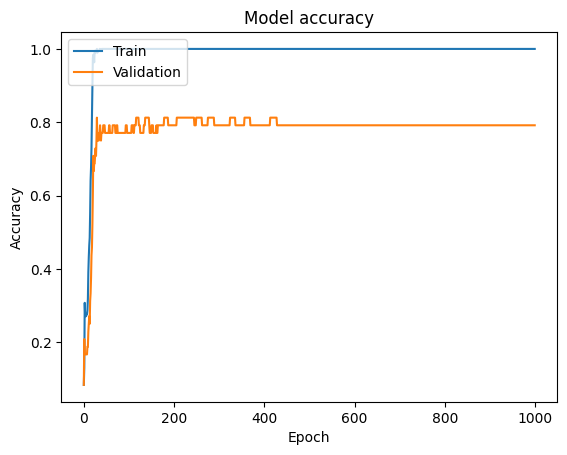

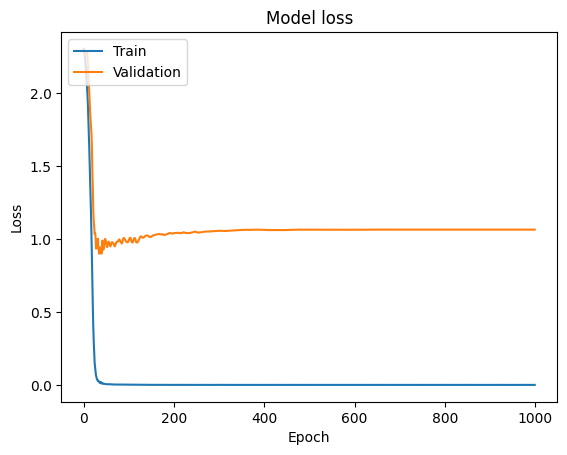

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Model testing

### 2. functon to classify intents from new text inputs

In [44]:
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenization
    tokens = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)
    return cleaned_text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
import numpy as np

def preprocess_text(text):
    # Your preprocessing steps here
    return text

def predict_intent_with_confidence(model, tokenizer, text):
    # Preprocess the text input
    cleaned_text = preprocess_text(text)

    # Tokenize and pad the preprocessed text
    random_sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_random_sequence = pad_sequences(random_sequence, maxlen=max_sequence_length)

    # Predict the intent probabilities
    intent_probabilities = model.predict(padded_random_sequence)[0]

    # Determine the predicted intent
    predicted_intent_index = np.argmax(intent_probabilities)
    predicted_intent = label_encoder.classes_[predicted_intent_index]

    # Calculate confidence score
    confidence_score = intent_probabilities[predicted_intent_index]

    return predicted_intent, confidence_score

# Example usage:
text_input = "How can I help you today?"
predicted_intent, confidence_score = predict_intent_with_confidence(model, tokenizer, text_input)
print("Predicted Intent:", predicted_intent)
print("Confidence Score:", confidence_score)


1/1 [==============================] - 0s 20ms/step
Predicted Intent: Inquiry:
Confidence Score: 0.9995259


### 3.Implement a fallback mechanism in your classifcaton functon. If the confdence score for the predicted intent is below the predefned threshold, return a fallback response (e.g., "NLU fallback: Intent could not be confdently determined")

In [46]:
import numpy as np

# Preprocess the random text input
random_text = "hi"
cleaned_text = preprocess_text(random_text)  # Assuming you have defined the preprocess_text function

# Tokenize and pad the preprocessed text
random_sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_random_sequence = pad_sequences(random_sequence, maxlen=max_sequence_length)

# Predict the intent probabilities
intent_probabilities = model.predict(padded_random_sequence)[0]

# Determine the predicted intent
predicted_intent_index = np.argmax(intent_probabilities)
predicted_intent = label_encoder.classes_[predicted_intent_index]

# Calculate confidence score
confidence_score = intent_probabilities[predicted_intent_index]

# Define confidence score threshold
confidence_threshold = 0.5  # Adjust this threshold as needed

# Check if confidence score is below threshold
if confidence_score < confidence_threshold:
    fallback_response = "NLU fallback: Intent could not be confidently determined"
    print(fallback_response)
else:
    print("Predicted Intent:", predicted_intent)
    print("Confidence Score:", confidence_score)


1/1 [==============================] - 0s 20ms/step
Predicted Intent: Greetings:
Confidence Score: 0.9990262


### 4. Test your model and classifcaton functon with random text inputs to ensure they provide the expected intent classifcatons along with confdence scores or fallback responses.

In [47]:

# Test function with random text inputs
random_texts = [
    "Hello there!",
    "Bye",
    "What's up?",
    "Good morning!",
    "I am very happy",
    "I'm doing well, thanks.",
    "It's a beautiful day today.",
    "I have a question for you.",
    "Can you help me with something?",
    "I'm excited for the weekend!"
]

for random_text in random_texts:
    print("Random Text:", random_text)
    # Preprocess the random text input
    cleaned_text = preprocess_text(random_text)

    # Tokenize and pad the preprocessed text
    random_sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_random_sequence = pad_sequences(random_sequence, maxlen=max_sequence_length)

    # Predict the intent probabilities
    intent_probabilities = model.predict(padded_random_sequence)[0]

    # Determine the predicted intent
    predicted_intent_index = np.argmax(intent_probabilities)
    predicted_intent = label_encoder.classes_[predicted_intent_index]

    # Calculate confidence score
    confidence_score = intent_probabilities[predicted_intent_index]

    # Define confidence score threshold
    confidence_threshold = 0.85  # Adjust this threshold as needed

    # Check if confidence score is below threshold
    if confidence_score < confidence_threshold:
        fallback_response = "NLU fallback: Intent could not be confidently determined"
        print(fallback_response)
    else:
        print("Predicted Intent:", predicted_intent)
        print("Confidence Score:", confidence_score)
    print()


Random Text: Hello there!
1/1 [==============================] - 0s 18ms/step
Predicted Intent: Greetings:
Confidence Score: 0.93923557

Random Text: Bye
1/1 [==============================] - 0s 18ms/step
Predicted Intent: Farewells:
Confidence Score: 0.99926525

Random Text: What's up?
1/1 [==============================] - 0s 19ms/step
NLU fallback: Intent could not be confidently determined

Random Text: Good morning!
1/1 [==============================] - 0s 18ms/step
Predicted Intent: Greetings:
Confidence Score: 0.9996437

Random Text: I am very happy
1/1 [==============================] - 0s 18ms/step
Predicted Intent: Greetings:
Confidence Score: 0.92194897

Random Text: I'm doing well, thanks.
1/1 [==============================] - 0s 17ms/step
Predicted Intent: Expressing Gratitude:
Confidence Score: 0.9943303

Random Text: It's a beautiful day today.
1/1 [==============================] - 0s 23ms/step
Predicted Intent: Inquiry:
Confidence Score: 0.9635184

Random Text: I ha

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 7, 128)            54528     
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 10)                650       
                                                                 
Total params: 162250 (633.79 KB)
Trainable params: 162250 (633.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
